# Feature Extraction for Leaf Classification (using similarity distance)
The generated Quasi Time-Series can be used as a useful feature in contructing a Leaf Classification algorithm.
The motivation was based on a recent competition in Kaggle: https://www.kaggle.com/c/leaf-classification. All details and inputs can be found in the above link (although the competition is closed!)

In [39]:
# first we import all necessary libraries

#I/O libs
import glob
import os
import time
from bar import Bar
from natsort import natsorted
from subprocess import check_output
import itertools  

# Common libs
import numpy as np
import pandas as pd
import seaborn as sns

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

# mlpy - Machine Learning Python see: http://mlpy.sourceforge.net/
import mlpy

# Scipy libraries
from scipy.misc import imread
import scipy.ndimage as ndi            # to determine shape centrality
from scipy.spatial import distance
from scipy.signal import argrelextrema

# Skimage lib for finding the contour
from skimage import measure            # to find shape contour
from skimage.measure import profile_line

%matplotlib inline
from pylab import rcParams 

In [40]:
#Checking the number of images in input directory
num_imgs = len(check_output(["ls", "./input/images/"]).decode("utf8").strip().split('\n'))
print("Number of leaf image files :", num_imgs)

Number of leaf image files : 100


###  Generating Quasi Time-Series based on Leaf's Outer Contour 

In [76]:
#obtaining all quasi time_series for into a list
time_series=[]
norm_time_series=[]

# looping through all images, extract their contour and quasi time-series.
with Bar("Extract img contours,profiles for training ..",count=num_imgs) as b:
    for filename in natsorted(glob.glob("./input/images/*.jpg")):
#        if os.path.basename(os.path.splitext(filename)[0]) in train_image:
            img = mpimg.imread(filename)                 #reading image file
            cy,cx = ndi.center_of_mass(img)              #calculating its center of mass
            contours = measure.find_contours(img, .8)    #finding all contours of an image using scikit-learn
            contour = max(contours, key=len)             #choosing the outest contour (edge of an image) using scikit-learn
            dist_values=np.zeros((int(len(contour)),2))
            for i in range(int(len(contour))):
                com=(cy,cx)
                dist=distance.euclidean(com,contour[i]) #generating quasi time-series by measuring euclidean of each point in outer contour from leaf center
                dist_values[i,0]=i
                dist_values[i,1]=dist
            norm_dist=dist_values/len(dist_values)      #normalizing the quasi time-series by the length of the leaf's contour - > 0 t 1
            time_series.append((os.path.basename(os.path.splitext(filename)[0]),dist_values))
            norm_time_series.append((os.path.basename(os.path.splitext(filename)[0]),norm_dist))
            time.sleep(0.001)
            b.step()

Extract img contours,profiles for training .. [████████████████████████████████████████████████████████████████████████████████████████████████████████] %100.00 Elapsed: 10s ETA: 0s


###  Let's look at two distinct images and their corresponding quasi time_series

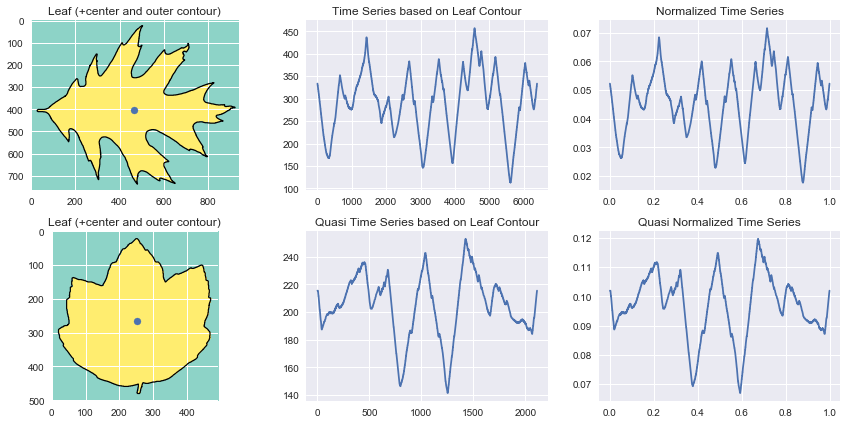

In [128]:
rcParams['figure.figsize'] = (12, 6)

# reading an image file using matplotlib into a numpy array
# looking at two distance images
img1 = mpimg.imread('./input/images/11.jpg')
cy1,cx1 = ndi.center_of_mass(img1) #using image processing module of scipy to find the center of the leaf

plt.subplot(231)
plt.title('Leaf (+center and outer contour)')
plt.imshow(img1,cmap='Set3')  # show me the leaf
contour1 = max(measure.find_contours(img1, .8), key=len)
plt.plot(contour1[::,1], contour1[::,0], linewidth=1.2, c='k') 

plt.scatter(cx1, cy1)           # show me its center
plt.subplot(232)
plt.title('Time Series based on Leaf Contour')
plt.plot(time_series[10][1][:,0],time_series[10][1][:,1])
plt.subplot(233)
plt.title('Normalized Time Series')
plt.plot(norm_time_series[10][1][:,0],norm_time_series[10][1][:,1])


img2 = mpimg.imread('./input/images/19.jpg')
cy2,cx2 = ndi.center_of_mass(img2) #using image processing module of scipy to find the center of the leaf

plt.subplot(234)
plt.title('Leaf (+center and outer contour)')
plt.imshow(img2,cmap='Set3')  # show me the leaf
contour2 = max(measure.find_contours(img2, .8), key=len)
plt.plot(contour2[::,1], contour2[::,0], linewidth=1.2, c='k')

plt.scatter(cx2, cy2)           # show me its center
plt.subplot(235)
plt.title('Quasi Time Series based on Leaf Contour')
plt.plot(time_series[18][1][:,0],time_series[18][1][:,1])
plt.subplot(236)
plt.title('Quasi Normalized Time Series')
plt.plot(norm_time_series[18][1][:,0],norm_time_series[18][1][:,1])

plt.tight_layout()
plt.show()

###  Calculating quasi time-series distances using standard Dynamic Time Warping

In [87]:
#Comparing two time-series using standard Dynamic Time Warping by calculating their similarity distances, see:
# https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html
# http://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering
# http://mlpy.sourceforge.net/

distances=[]
distances=np.zeros((len(norm_time_series),len(norm_time_series)))

with Bar("Calculating all pairwise distances..",count=len(norm_time_series)**2) as b:
    for i,j in itertools.permutations(np.arange(0,len(norm_time_series)), 2):
        dist, cost, path =mlpy.dtw_std(norm_time_series[i][1][:,1], norm_time_series[j][1][:,1],dist_only=False)
        distances[i][j]=dist
        time.sleep(0.001)
        b.step()

Calculating all pairwise distances.. [███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ ] %98.99 Elapsed: 672s ETA: 7s


In [88]:
# putting all distances into a Pandas dataframe

df_distances=pd.DataFrame(distances)

In [89]:
df_distances.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,31.827549,15.952643,25.595922,10.652493,31.892274,24.137947,38.645768,89.126224,35.519418,...,45.243964,30.172599,16.496436,135.024078,13.511489,15.041278,50.171044,18.089530,13.316335,11.973869
1,31.827549,0.000000,16.906746,30.656100,38.648349,5.224677,15.265227,22.674311,80.153770,7.784372,...,43.527783,31.908114,23.656319,109.547662,45.002388,41.536089,6.221112,47.340248,39.476695,18.667741
2,15.952643,16.906746,0.000000,22.766569,23.476338,13.393146,17.994733,20.518000,104.941685,16.120580,...,45.956138,24.721041,13.674677,156.299550,26.567427,22.146544,27.622932,28.709925,26.010058,5.052695
3,25.595922,30.656100,22.766569,0.000000,25.189599,34.078403,40.648058,20.643354,146.382024,42.103028,...,98.440421,5.512884,29.594528,189.273759,23.188439,26.169516,55.959088,19.968512,16.460571,19.826274
4,10.652493,38.648349,23.476338,25.189599,0.000000,43.683372,34.913364,42.517390,90.879277,49.761284,...,61.587849,27.679269,23.056874,141.932129,23.438245,8.285917,70.058946,30.985452,9.149102,17.478455


## Results: 

### Heatmap of Similarity Distances
The smaller values whih are shown darker are images which have higher probability to be identical.

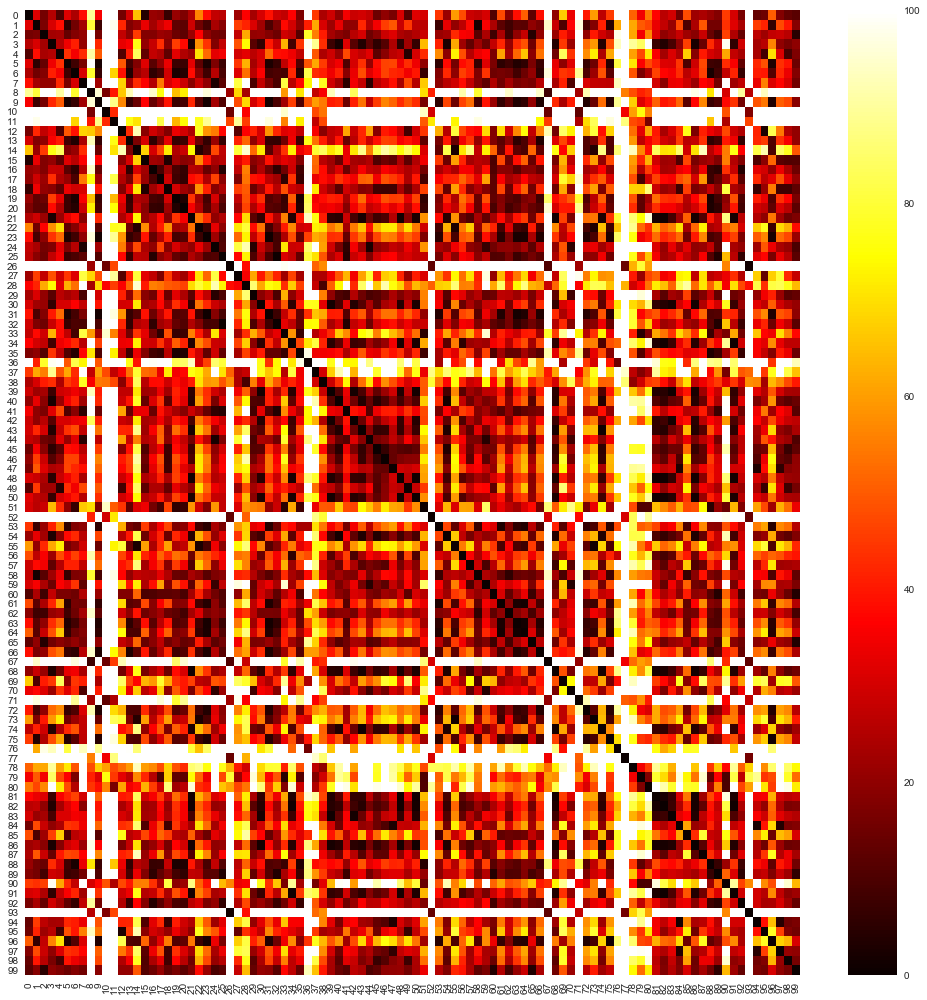

In [127]:
plt.rcParams['figure.figsize']=14,14
sns.heatmap(df_distances,cmap = 'hot',vmin=0,vmax=100)#'YlGnBu')
plt.tight_layout()

### Let's find two images that we found to be in close distance; which by definition are supposed to be identical

In [129]:
# We will looking at distances of Img. 19 (shown above) with all other 99 images and sorting out the values in ascending order. 
df_distances[18].sort_values().head()

18    0.000000
15    3.351344
94    6.671682
0     6.809134
84    7.608399
Name: 18, dtype: float64

As can be seen the distance of Img. 19 (because of python indexing from zero it is shown as 18) is closest to Image 16 (index 15) with distance less than 3.5 in magnitude, so let's look at Img. 19 and 16 and their corresponding normalized quasi time-series.

### Let's look at these two images (Img. 19 and 15) 

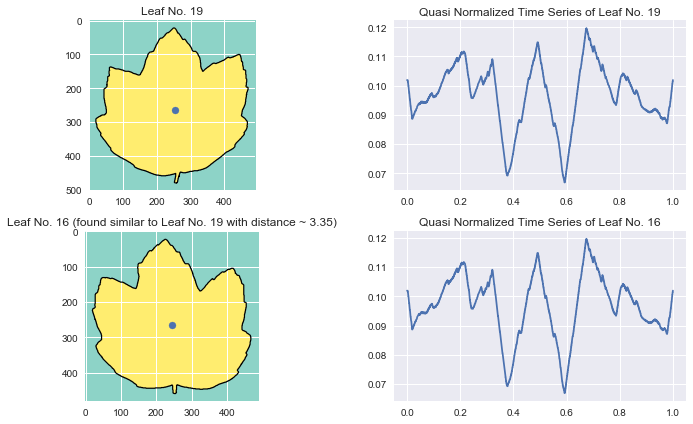

In [125]:
plt.rcParams['figure.figsize']=10,6


img1 = mpimg.imread('./input/images/19.jpg')
cy2,cx2 = ndi.center_of_mass(img1) #using image processing module of scipy to find the center of the leaf

plt.subplot(221)
plt.title('Leaf No. 19')
plt.imshow(img1,cmap='Set3')  # show me the leaf
contour1 = max(measure.find_contours(img1, .8), key=len)
plt.plot(contour1[::,1], contour1[::,0], linewidth=1.2, c='k')

plt.scatter(cx2, cy2)           # show me its center
plt.subplot(222)
plt.title('Quasi Normalized Time Series of Leaf No. 19')
plt.plot(norm_time_series[18][1][:,0],norm_time_series[18][1][:,1])

img2 = mpimg.imread('./input/images/16.jpg')
cy2,cx2 = ndi.center_of_mass(img2) #using image processing module of scipy to find the center of the leaf

plt.subplot(223)
plt.title('Leaf No. 16 (found similar to Leaf No. 19 with distance ~ 3.35)')
plt.imshow(img2,cmap='Set3')  # show me the leaf
contour2 = max(measure.find_contours(img2, .8), key=len)
plt.plot(contour2[::,1], contour2[::,0], linewidth=1.2, c='k')

plt.scatter(cx2, cy2)           # show me its center
plt.subplot(224)
plt.title('Quasi Normalized Time Series of Leaf No. 16')
plt.plot(norm_time_series[18][1][:,0],norm_time_series[18][1][:,1])

plt.tight_layout()
plt.show()

Hoooray!! ^_^ 
These two images seem to be identical as predicted by our similarity measure which can be be verified by naked eyes. This feature can be used further to build a machine learning classification algorithm. 